## OpenCV Age Detection with Deep Learning - PyImage Search by Adrian Rosebrock

Source: https://www.pyimagesearch.com/2020/04/13/opencv-age-detection-with-deep-learning/

In this tutorial, I learn how to perform automatic age detection for both static images and video-streams.

There are a number of age detector algorithms, but the most popular ones are deep learning-based age detectors — we’ll be using such a deep learning-based age detector in this tutorial.

Key Take-aways:
- Two stages involved: 
    - Detect faces
    - Extract ROI and apply age detector algorithm. The face ROI is  passed through the model, yielding the actual age prediction.
- Why is age detection best treated as a classification problem than a regression problem? Even with humans, it is easier predicting age brackets than a single age. A rough estimate is sufficient.
- The deep learning age detector model used was implemented and trained by Levi and Hassner in their 2015 publication, Age and Gender Classification Using Convolutional Neural Networks [https://talhassner.github.io/home/publication/2015_CVPR].
- The models AlexNet-like architecture learns 8 age brackets (0-2, 4-6, 8-12, 15-20, 25-32, 38-43, 48-53, 60-100) 

In [12]:
# Import relevant libraries
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import imutils
import time
from imutils.video import VideoStream

In [2]:

# Define the list of age buckets our age detector will predict
age_bucket = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)",
              "(38-43)", "(48-53)", "(60-100)"]

# These models were trained using the Caffe framework.
# Load serialized face detector model
print("[INFO] Loading face detector model...")
prototxt_path = "face_detector/deploy.prototxt"
weights_path = "face_detector/res10_300x300_ssd_iter_140000.caffemodel"
    
face_net = cv2.dnn.readNet(prototxt_path, weights_path)
    
# Load serialized age detector model
print("[INFO] Loading age detector model...")
prototxt_path = "age_detector/age_deploy.prototxt"
weights_path = "age_detector/age_net.caffemodel"

age_net = cv2.dnn.readNet(prototxt_path, weights_path)

print("Both models have been loaded.")

[INFO] Loading face detector model...
[INFO] Loading age detector model...
Both models have been loaded.


First, we implement age detection on Static images.

In [7]:
# Create function to take in image as input and produce
# age detected.

def detect_age_image(image):
    # Load the input image and construct an input blob for 
    # the image
    image = cv2.imread(image)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
                                (104.0, 177.0, 123.0))
    
    # Pass the blob through the network and obtain face detections
    print("[INFO] Computing face detections...")
    face_net.setInput(blob)
    detections = face_net.forward()
    
    #print(f"What detection looks like: {detection}")
    
    # Loop over face ROI detections
    for i in range(0, detections.shape[2]):
        
        # Extract confidence associated with the prediction
        confidence = detections[0, 0, i, 2]
        
        # Filter out weak detections by ensuring the confidence is 
        # greater than 0.6
        if confidence > 0.6:
            
            # Compute the x,y coordinates of bounding box
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (start_x, start_y, end_x, end_y) = box.astype("int")
            
            # Extract the ROI and construct a blob from only face ROI
            face = image[start_y:end_y, start_x:end_x]
            face_blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),
                                             (78.4263377603, 87.7689143744, 114.895847746),
                                             swapRB=False)
            
            # Make predictions on the age and find age bucket
            age_net.setInput(face_blob)
            preds = age_net.forward()
            i = preds[0].argmax()
            age = age_bucket[i]
            age_conf = preds[0][i]
            
            # Display the predicted age 
            text = "{}: {:.2f}%".format(age, age_conf * 100)
            print("[INFO] {}".format(text))
            
            # Draw the bounding box of the face along with predicted
            # age
            y = start_y - 10 if start_y - 10 > 10 else start_y + 10
            cv2.rectangle(image, (start_x, start_y), (end_x, end_y),
                         (0, 0, 255), 2)
            cv2.putText(image, text, (start_x, y),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
            
    cv2.imshow("Image", image)
    plt.imshow(image)
    cv2.waitKey(0)
        

[INFO] Computing face detections...
[INFO] (8-12): 79.03%


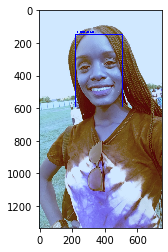

In [8]:
detect_age_image("images/mofe.jpg")

[INFO] Computing face detections...
[INFO] (25-32): 57.51%


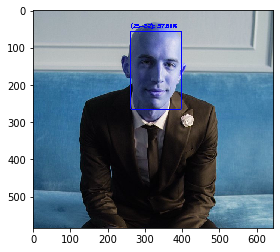

In [9]:
detect_age_image("images/adrian.png")

[INFO] Computing face detections...
[INFO] (25-32): 30.98%


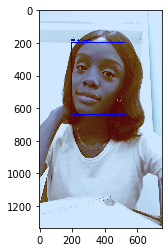

In [10]:
detect_age_image("images/mofe2.jpg")

Okay I guess I look different in both photos. I'm actually 22 in both haha :). But let's see if it would be able to predict my real age using the video stream

In [19]:
def detect_age_video(frame):
    
    # Initialize our results list
    results = []
    
    # Grab dimensions of the frame and construct blob
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
                                (104.0, 177.0, 123.0))
    
    # Pass blob through network and obtain face detection
    face_net.setInput(blob)
    detections = face_net.forward()
    
    # Loop over detections
    for i in range(0, detections.shape[2]):
        
        # Extract confidence
        confidence = detections[0, 0, i, 2]
        
        # Filter weak detections
        if confidence > 0.6:
            
            # Compute the x,y coordinates of bounding box
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (start_x, start_y, end_x, end_y) = box.astype("int")
            
            # Extract the ROI 
            face = frame[start_y:end_y, start_x:end_x]
            
            # Ensure the face ROI is sufficiently large
            if face.shape[0] < 20 or face.shape[1] < 20:
                continue
                
            # Construct a blob from face ROI
            face_blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),
                                              (78.4263377603, 87.7689143744, 114.895847746),
                                              swapRB=False)
            
            # Make predictions on the age
            age_net.setInput(face_blob)
            preds = age_net.forward()
            i = preds[0].argmax()
            age = age_bucket[i]
            age_conf = preds[0][i]
            
            # Construct a dictionary consisting of both the bounding 
            # box location and age prediction and update results list
            d = {
                "loc": (start_x, start_y, end_x, end_y),
                "age": (age, age_conf)
            }
            results.append(d)
            
    return results
        
        

[INFO] Starting video stream...


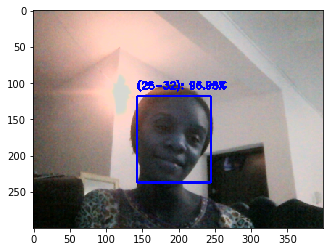

In [23]:
# Initialize video stream and warm-up camera
print("[INFO] Starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
    
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    
    # detect face and predict age for each frame
    results = detect_age_video(frame)
    
    # Loop over results
    for r in results:
        
        # Draw bounding box along with predicted age
        text = "{}: {:.2f}%".format(r["age"][0], r["age"][1] * 100)
        (start_x, start_y, end_x, end_y) = r["loc"]
        y = start_y - 10 if start_y - 10 > 10 else start_y + 10
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y),
                      (0, 0, 255), 2)
        cv2.putText(frame, text, (start_x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        
    # Show the output frame
    cv2.imshow("Frame", frame)
    plt.imshow(frame)
    key = cv2.waitKey(1) & 0xFF
    
    # Break loop if e is pressed
    if key == ord("e"):
        break
        
cv2.destroyAllWindows()
vs.stop()
    

Okay, the prediction of the last frame is incorrect as seen in the plot above, but while streaming the prediction kept fluctuating between 4-6, 8-12, 25-32, with more of 25-32. And since there is no range for my current age, I guess 25-32 should work fine.